# Nonlinear Buckling of a Box Beam Reinforced with Ribs and Stiffeners

***

* [Setup of the numerical model](#numerical-model)
* [Mesh convergence study](#mesh-convergence)
* [Nonlinear analysis: sensitivity of nonlinear analysis paramters](#parameters)
* [Nonlinear analysis: tangent stiffness matrix approach](#tangent-stiffness-matrix)
* [Conclusions](#conclusions)

## Setup of the numerical model <a name="numerical-model"></a>

***

Planform geometry.

In [95]:
AR = 9   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


Ribs.

In [96]:
import numpy as np

# Prescribed spacing
ribs_spacing = w/2
# Number of ribs based on prescribed spacing
no_ribs = int(np.ceil(b/ribs_spacing)) + 1
print(f'Number of ribs: {no_ribs:.0f}')
# Find prescribed ribs location
ribs_y_locations = np.linspace(0, b, no_ribs)

Number of ribs: 10


Stringers.

In [97]:
# Prescribed spacing
stringers_spacing = ribs_spacing/1.4
# Prescribed height
stringers_height = h/10
# Number of stringers based on prescribed spacing
no_stringers = int(np.ceil(w/stringers_spacing)) - 1
print(f'Number of stringers: {no_stringers:.0f}')
# Find prescribed stringers location
stringers_x_locations = np.linspace(0, w, no_stringers + 2)[1:-1]
print('Stringers x position [mm]:')
np.set_printoptions(precision=0)
print(stringers_x_locations)
print(f'Stringers height: {stringers_height:.0f} mm')

Number of stringers: 2
Stringers x position [mm]:
[333. 667.]
Stringers height: 20 mm


Material properties

In [98]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

Mesh.

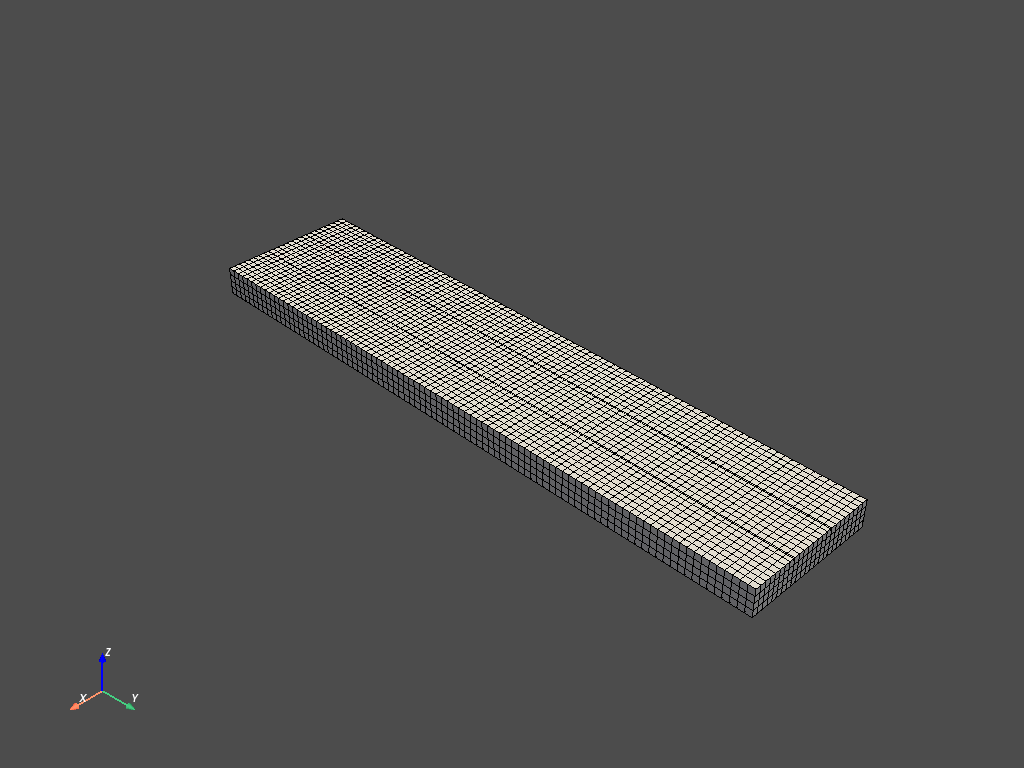

In [99]:
import pyvista
from resources import box_beam_utils

def mesh_stiffened_box_pyvista(box_width, box_span, box_height, stringers_x_coordinates, stringers_height, edge_length, y_0 = 0.):
    # Find number of elements along each side of the box based on the prescribed edge length. We make sure that there is an even number of elements over each dimension to better approximate the buckling shape
    no_elements = [np.ceil(side/edge_length/2).astype('int')*2 for side in [box_height, box_span]]
    # Discretize front spar of the stiffened box
    front_spar_mesh = pyvista.Plane(center=[0, y_0 + box_span/2, 0], direction=[-1, 0, 0], i_size=box_height,
                                    j_size=box_span, i_resolution=no_elements[0], j_resolution=no_elements[1])
    # Discretize rear spar of the box
    rear_spar_mesh = pyvista.Plane(center=[box_width, y_0 + box_span/2, 0], direction=[1, 0, 0], i_size=box_height,
                                   j_size=box_span, i_resolution=no_elements[0], j_resolution=no_elements[1])
    # Initialize lists of the PolyData objects corresponding to the box segments and to the ribs
    top_skin_meshes = []
    top_stringers_meshes = []
    bottom_skin_meshes = []
    bottom_stringers_meshes = []
    no_stringer_elements = np.ceil(stringers_height/edge_length/2).astype('int')*2
    x_0 = 0
    # Iterate through the x-coordinates of the stringers, except last one
    for count, x in enumerate(stringers_x_coordinates):
        # Find number of elements along the width
        no_width_elements = np.ceil((x - x_0)/edge_length/2).astype('int')*2
        # Discretize top skin segment
        top_skin_meshes.append(pyvista.Plane(center=[(x_0 + x)/2, y_0 + box_span/2, box_height/2], direction=[0, 0, 1], i_size=x - x_0, j_size=box_span, i_resolution=no_width_elements, j_resolution=no_elements[1]))
        # Discretize top stringer
        top_stringers_meshes.append(pyvista.Plane(center=[x, y_0 + box_span/2, box_height/2 - stringers_height/2], direction=[1, 0, 0], i_size=stringers_height, j_size=box_span, i_resolution=no_stringer_elements, j_resolution=no_elements[1]))
        # Discretize bottom skin segment
        bottom_skin_meshes.append(pyvista.Plane(center=[(x_0 + x)/2, y_0 + box_span/2, -box_height/2], direction=[0, 0, -1], i_size=x - x_0, j_size=box_span, i_resolution=no_width_elements, j_resolution=no_elements[1]))
        # Discretize bottom stringer
        bottom_stringers_meshes.append(pyvista.Plane(center=[x, y_0 + box_span/2, -box_height/2 + stringers_height/2], direction=[1, 0, 0], i_size=stringers_height, j_size=box_span, i_resolution=no_stringer_elements, j_resolution=no_elements[1]))
        # Update x_0
        x_0 = x
    # Discretize last rib-stringer bay of the skins
    no_width_elements = np.ceil((w - x_0)/edge_length/2).astype('int')*2
    top_skin_meshes.append(pyvista.Plane(center=[(x_0 + w)/2, y_0 + box_span/2, box_height/2], direction=[0, 0, 1], i_size=w - x_0, j_size=box_span, i_resolution=no_width_elements, j_resolution=no_elements[1]))
    bottom_skin_meshes.append(pyvista.Plane(center=[(x_0 + w)/2, y_0 + box_span/2, -box_height/2], direction=[0, 0, -1], i_size=w - x_0, j_size=box_span, i_resolution=no_width_elements, j_resolution=no_elements[1]))
    # Merge all box segments and ribs together
    merged_box_beam_mesh = front_spar_mesh.merge([rear_spar_mesh] + top_skin_meshes + top_stringers_meshes + bottom_skin_meshes + bottom_stringers_meshes)
    # Clean obtained mesh merging points closer than indicated tolerance
    cleaned_box_beam_mesh = merged_box_beam_mesh.clean(tolerance=edge_length/100)
    # Return cleaned mesh
    return cleaned_box_beam_mesh

def mesh_stiffened_box_beam_pyvista(width, height, ribs_y_coordinates, stringers_x_coordinates, stringers_height, edge_length):
    # Initialize lists of the PolyData objects corresponding to the box segments and to the ribs
    stiffened_box_meshes = []
    rib_meshes = []
    rib_x_coordinates = np.concatenate(([0.], stringers_x_coordinates, [w]))
    rib_widths = np.ediff1d(rib_x_coordinates)
    # Iterate through the y-coordinates of the rib, except last one
    for count, y in enumerate(ribs_y_coordinates[:-1]):
        # Discretize box segment between current and next rib and add PolyData object to the list
        stiffened_box_meshes.append(mesh_stiffened_box_pyvista(width, ribs_y_coordinates[count+1]-y, height, stringers_x_coordinates, stringers_height, edge_length, y))
        # Discretize current rib and add PolyData object to the list
        rib_meshes = rib_meshes + [box_beam_utils.mesh_rib_pyvista(y, rib_widths[i], height, edge_length, rib_x_coordinates[i]) for i in range(len(rib_widths))]
    # Discretize last rib and add PolyData object to the list
    rib_meshes = rib_meshes + [box_beam_utils.mesh_rib_pyvista(ribs_y_coordinates[-1], rib_widths[i], height, edge_length, rib_x_coordinates[i]) for i in range(len(rib_widths))]
    # Merge all box segments and ribs together
    # test = rib_meshes[0].merge(rib_meshes[1:])
    merged_box_beam_mesh = stiffened_box_meshes[0].merge(stiffened_box_meshes[1:] + rib_meshes)
    # Clean obtained mesh merging points closer than indicated tolerance
    cleaned_box_beam_mesh = merged_box_beam_mesh.clean(tolerance=edge_length/100)
    # Return cleaned mesh
    return cleaned_box_beam_mesh

edge_length = 50
# mesh1 = mesh_stiffened_box_pyvista(w, ribs_y_locations[1], h, stringers_x_locations, stringers_height, edge_length)
mesh = mesh_stiffened_box_beam_pyvista(w, h, ribs_y_locations, stringers_x_locations, stringers_height, edge_length)
mesh.plot(show_edges=True, jupyter_backend='static')

## Mesh convergence study <a name="mesh-convergence"></a>

***


In [100]:
from resources import pynastran_utils

def apply_tip_concentrated_load(bdf_input, mesh, force_id):
    # Store array of nodes ids
    nodes_coordinates_array = mesh.points
    # Find outer nodes of tip rib
    nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
    tolerance = t/25
    outer_tip_nodes_ids = nodes_ids[(np.abs(nodes_coordinates_array[:, 1] - b) < tolerance) & ((nodes_coordinates_array[:, 0] < tolerance) | (np.abs(nodes_coordinates_array[:, 0] - w) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] - h/2) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] + h/2) < tolerance))]
    # Add master node of tip section
    tip_section_master_node_id = np.amax(nodes_ids) + 1
    bdf_input.add_grid(tip_section_master_node_id, [w/2, b, 0.])
    # Add RBE3 to connect master node with outer nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=tip_section_master_node_id, refc='123456', weights=[1.]*len(outer_tip_nodes_ids), comps=['123456']*len(outer_tip_nodes_ids), Gijs=outer_tip_nodes_ids)
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_unitary_force(bdf_object=bdf_input, nodes_ids=[tip_section_master_node_id], set_id=force_id, direction_vector=force_direction)
    # Return id of master node
    return tip_section_master_node_id

In [101]:
import matplotlib.pyplot as plt  # plotting library
import os

# Set default dpi of figures
plt.rcParams['figure.dpi'] = 150
# Define name of analysis directory and of input file
analysis_directory_name = '12_Nonlinear_Buckling_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Define set id of FORCE card
force_set_id = 11
# Define edge length of the shell elements to be used for the mesh convergence study
shell_element_edges = np.geomspace(h, t*4, 10) # [mm]
print('Prescribed edge length of shell elements for mesh convergence study [mm]:')
np.set_printoptions(precision=0)
print(shell_element_edges)
# Initialize arrays with number of degrees of freedom and linear buckling load
dofs = np.empty(np.shape(shell_element_edges))
linear_buckling_loads = np.ones(np.shape(shell_element_edges))
# Iterate through the shell element lengths
for i, edge in enumerate(shell_element_edges):
    # Generate bdf input
    box_beam_mesh = mesh_stiffened_box_beam_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations, stringers_x_coordinates=stringers_x_locations, stringers_height=stringers_height, edge_length=edge)
    box_beam_bdf_input = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_mesh.points, box_beam_mesh.faces.reshape(-1, 5)[:, 1:])
    # Store number of degrees of freedom
    constrained_nodes_ids = next(iter(box_beam_bdf_input.spcs.values()))[0].node_ids
    dofs[i] = (len(box_beam_bdf_input.nodes) - len(constrained_nodes_ids))*6
    # Print info about current analysis
    no_elements = len(box_beam_bdf_input.elements)
    print(f'\n\033[1mResults for model with:\n- {edge:.1f} mm shell element linear size\n- {no_elements:.0f} elements\n- {dofs[i]:.0f} degrees of freedom\033[0m')
    # Apply uniform load
    apply_tip_concentrated_load(box_beam_bdf_input, box_beam_mesh, force_set_id)
    # Calculate linear buckling load and plot shape
    input_name = 'linear_buckling_' + str(no_elements) + '_elements'
    linear_buckling_loads[i] = box_beam_utils.calculate_linear_buckling_load(box_beam_bdf_input, force_set_id, analysis_directory_path, input_name, run_flag=False, plot_shape=False)

Prescribed edge length of shell elements for mesh convergence study [mm]:
[200. 151. 114.  86.  65.  49.  37.  28.  21.  16.]

Results for model with:
- 200.0 mm shell element linear size
- 984 elements
- 5454 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 10448 N

Results for model with:
- 151.1 mm shell element linear size
- 1536 elements
- 8370 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 9375 N

Results for model with:
- 114.1 mm shell element linear size
- 2184 elements
- 12258 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 8849 N

Results for model with:
- 86.2 mm shell element linear size
- 2640 elements
- 14742 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 8839 N


subcase=0 already exists...skipping



Results for model with:
- 65.1 mm shell element linear size
- 4464 elements
- 25218 degrees of freedom
Nastran job linear_buckling_4464_elements.bdf completed
Wall time: 2.0 s


Buckling load: 8554 N


subcase=0 already exists...skipping



Results for model with:
- 49.2 mm shell element linear size
- 8784 elements
- 50274 degrees of freedom
Nastran job linear_buckling_8784_elements.bdf completed
Wall time: 5.0 s


Buckling load: 8424 N


subcase=0 already exists...skipping



Results for model with:
- 37.1 mm shell element linear size
- 11880 elements
- 68310 degrees of freedom
Nastran job linear_buckling_11880_elements.bdf completed
Wall time: 6.0 s


Buckling load: 8396 N


subcase=0 already exists...skipping



Results for model with:
- 28.0 mm shell element linear size
- 18432 elements
- 106542 degrees of freedom
Nastran job linear_buckling_18432_elements.bdf completed
Wall time: 11.0 s


Buckling load: 8375 N


subcase=0 already exists...skipping



Results for model with:
- 21.2 mm shell element linear size
- 31584 elements
- 183330 degrees of freedom
Nastran job linear_buckling_31584_elements.bdf completed
Wall time: 23.0 s


Buckling load: 8468 N


subcase=0 already exists...skipping



Results for model with:
- 16.0 mm shell element linear size
- 57624 elements
- 335934 degrees of freedom
Nastran job linear_buckling_57624_elements.bdf completed
Wall time: 52.0 s


Buckling load: 8358 N


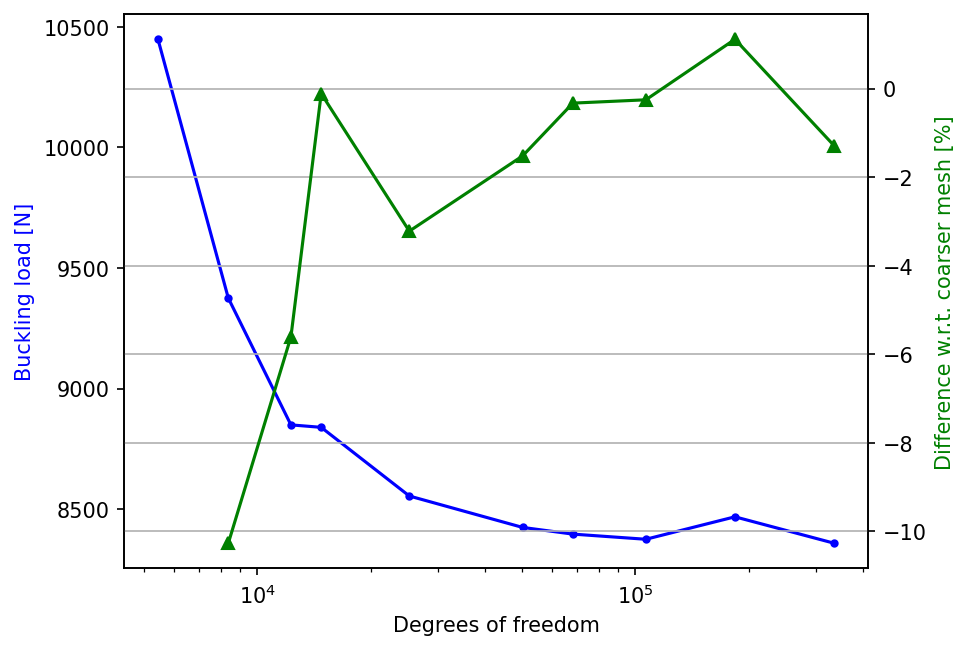

In [102]:
# Plot degrees of freedom vs buckling loads with a log scale along the x-axis
plt.semilogx(dofs, linear_buckling_loads, 'b.-')
# Add second y-axis on the right of the plot
ax1 = plt.gca()
ax2 = ax1.twinx()
# Calculate the percentage difference of each buckling load with respect to the one obtained with the coareser mesh
percentage_diff = (linear_buckling_loads[1:]/linear_buckling_loads[0:-1]-1)*100
# Plot degrees of freedom vs the percentage difference
ax2.plot(dofs[1:], percentage_diff, 'g^-')
# Set the axes label and the grid
ax1.set_xlabel('Degrees of freedom')
ax1.set_ylabel('Buckling load [N]', color='b')
ax2.set_ylabel('Difference w.r.t. coarser mesh [%]', color='g')
plt.grid()
plt.show()

In [103]:
# Find shell element size, degrees of freedom and buckling load corresponding to converged mesh
converged_mesh_index = np.where(np.abs(percentage_diff)<2)[0][1]+1
converged_shell_element_edge = shell_element_edges[converged_mesh_index]
sol105_buckling_load = linear_buckling_loads[converged_mesh_index]
print(f'The mesh is converged for an approximate shell element size of {converged_shell_element_edge:.0f} mm, corresponidng to {dofs[converged_mesh_index]:.0f} degrees of freedom and to a linear buckling load of {sol105_buckling_load:.0f} N.')

The mesh is converged for an approximate shell element size of 49 mm, corresponidng to 50274 degrees of freedom and to a linear buckling load of 8424 N.


## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="parameters"></a>

***

Reference nonlinear analysis with default parameters.

In [104]:
# Create BDF object with nodes, elements, material properties and boundary conditions
box_beam_mesh = mesh_stiffened_box_beam_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations, stringers_x_coordinates=stringers_x_locations, stringers_height=stringers_height, edge_length=converged_shell_element_edge)
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_mesh.points, box_beam_mesh.faces.reshape(-1, 5)[:, 1:])
# Apply concentrated load at tip equal to twice the buckling load predicted by SOL 105
tip_master_node_id = apply_tip_concentrated_load(box_beam_bdf_input, box_beam_mesh, force_set_id)
load_set_id = force_set_id+1
scale_factor = sol105_buckling_load*2
box_beam_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
# Create static load subcase
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=1, load_set_id=load_set_id)
# Setup SOL 106 with nonlinear analysis parameters
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf_input)

subcase=0 already exists...skipping


Nastran job nonlinear_analysis_reference.bdf completed
Wall time: 51.0 s


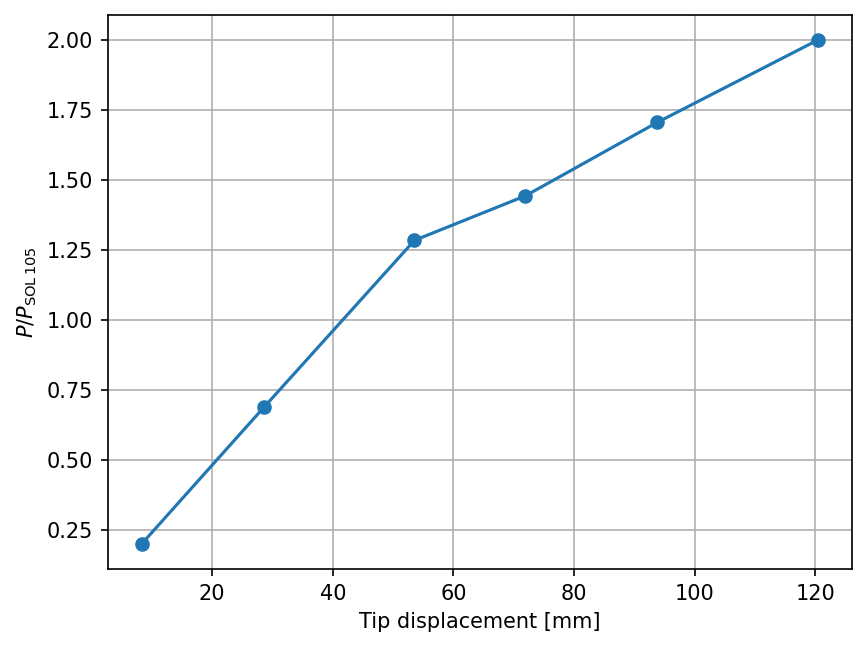

(<Figure size 960x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

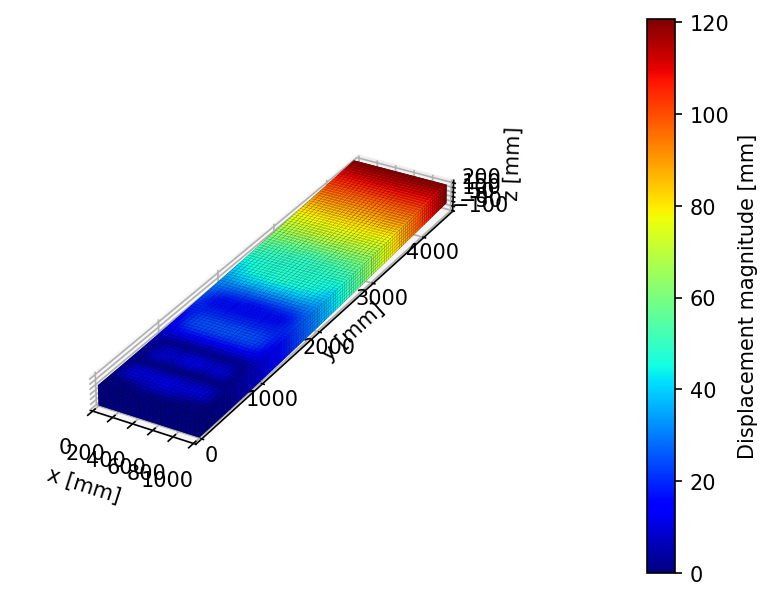

In [105]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
from pyNastran.op2.op2 import read_op2  # function to read op2 file

# Get list of marker characters
markers = list(Line2D.markers.keys())[2:]
# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2

def plot_load_displacement_path(op2, axes, marker_style, line_label=''):
    # Read load and displacement history from op2 file
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_master_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,displacement_component_index], p[1][:, load_component_index]/sol105_buckling_load, marker=marker_style, linestyle='-', label=line_label)

# Run analysis
input_filename = 'nonlinear_analysis_reference'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False, load_geometry=True)
# Plot load-displacement path
_, ax = plt.subplots()
plot_load_displacement_path(op2_output, ax, markers[0])
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.grid()
plt.show()
# Plot structural deformation
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output)
ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='z', nbins=2)
ax.tick_params(axis='y', which='major', pad=20)
ax.tick_params(axis='z', which='major', pad=6)
ax.yaxis.labelpad = 60
ax.zaxis.labelpad = 10
plt.show()

Error function.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 51.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 51.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 49.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 50.0 s


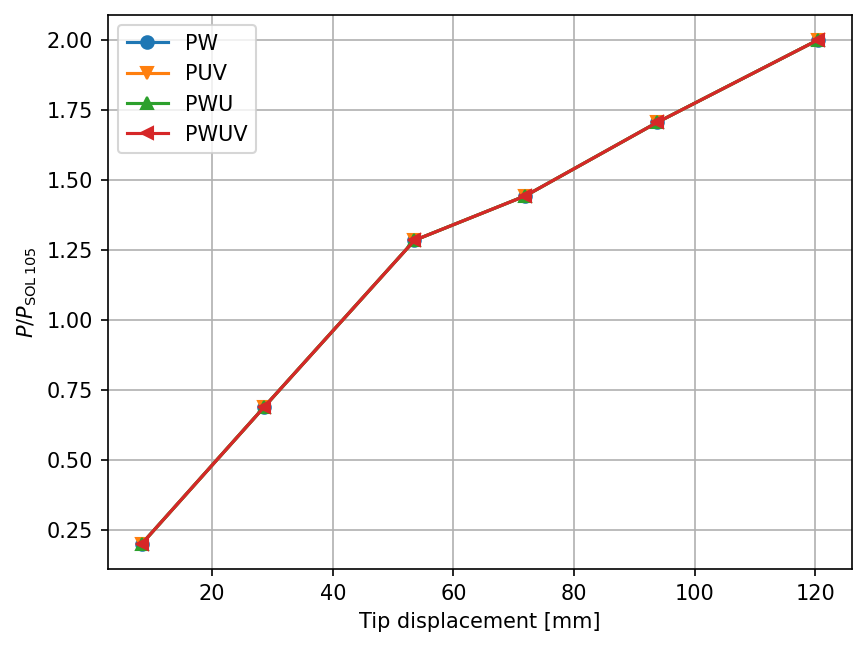

In [106]:
# Define error functions
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']
# Create figure
_, ax = plt.subplots()
# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf_input.nlparms[1].conv = fun
    input_filename = 'nonlinear_analysis_error_function_' + fun
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, debug=False)
    plot_load_displacement_path(op2_output, ax, markers[count], f'{fun}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

In [107]:
box_beam_bdf_input.nlparms[1].conv = 'PW'

Convergence tolerances.

Nastran job nonlinear_analysis_load_tolerance_0_100.bdf completed
Wall time: 44.0 s


Nastran job nonlinear_analysis_load_tolerance_0_010.bdf completed
Wall time: 48.0 s


Nastran job nonlinear_analysis_load_tolerance_0_001.bdf completed
Wall time: 46.0 s


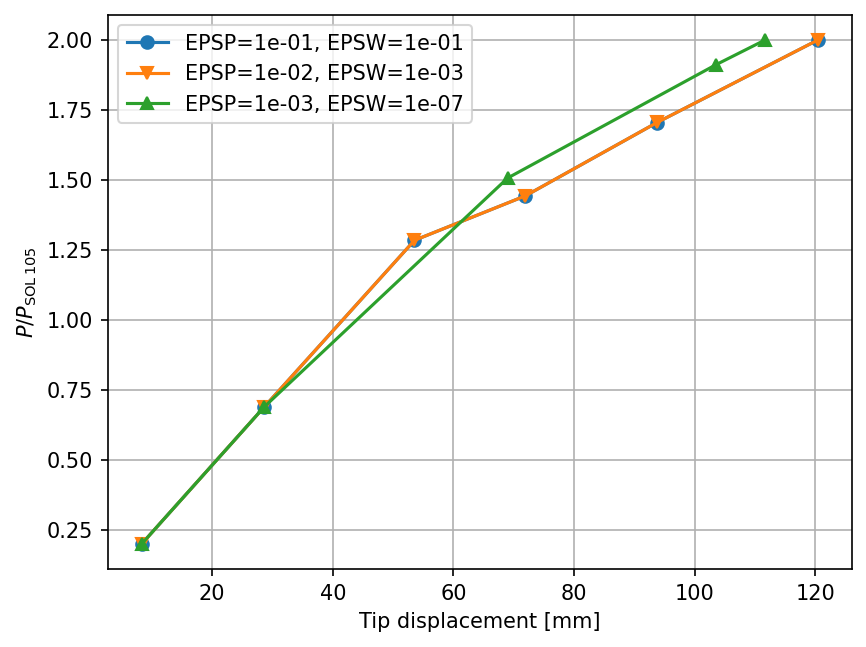

In [108]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]
# Create figure
_, ax = plt.subplots()
# Run analysis for each couple of convergence tolerances and plot load-displacement diagram
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf_input.nlparms[1].eps_p = epsp
    box_beam_bdf_input.nlparms[1].eps_w = epsw
    input_filename = f'nonlinear_analysis_load_tolerance_{epsp:.3f}'.replace('.','_')
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, debug=False)
    plot_load_displacement_path(op2_output, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Initial load increment.

Nastran job nonlinear_analysis_initial_load_increment_0_50.bdf completed
Wall time: 25.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_10.bdf completed
Wall time: 55.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_01.bdf completed
Wall time: 72.0 s


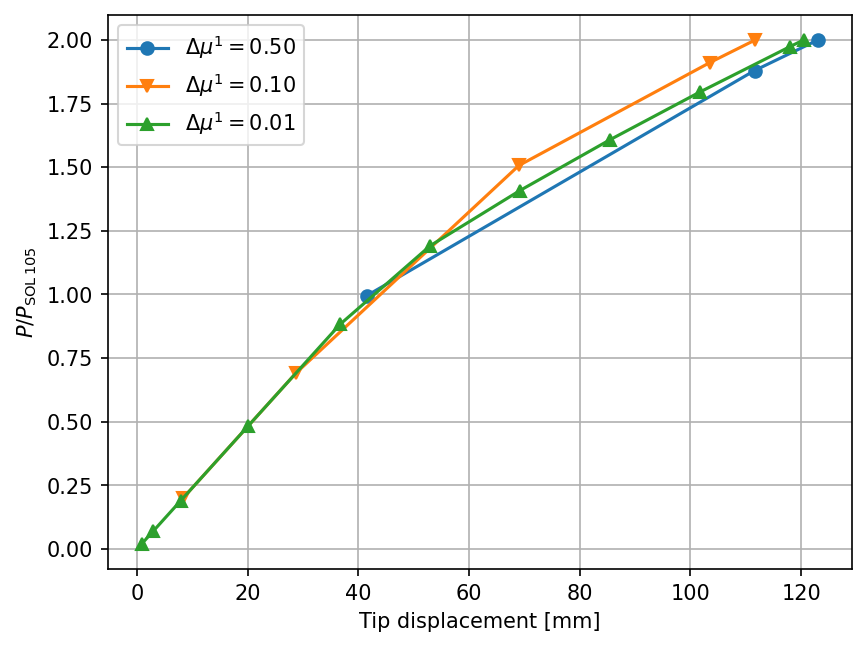

In [109]:
# Define initial load increments
initial_load_increments = [.5, .1, .01]
# Create figure
_, ax = plt.subplots()
# Run analysis for each initial load increment and plot load-displacement diagram
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf_input.nlparms[1].ninc = int(1/delta_mu_1)
    input_filename = f'nonlinear_analysis_initial_load_increment_{delta_mu_1:.2f}'.replace('.','_')
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, debug=False)
    plot_load_displacement_path(op2_output, ax, markers[count], f'$\Delta\mu^1={delta_mu_1:.2f}$')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Desired number of iterations.

Nastran job nonlinear_analysis_desiter_20.bdf completed
Wall time: 104.0 s


Nastran job nonlinear_analysis_desiter_12.bdf completed
Wall time: 67.0 s


Nastran job nonlinear_analysis_desiter_5.bdf completed
Wall time: 98.0 s


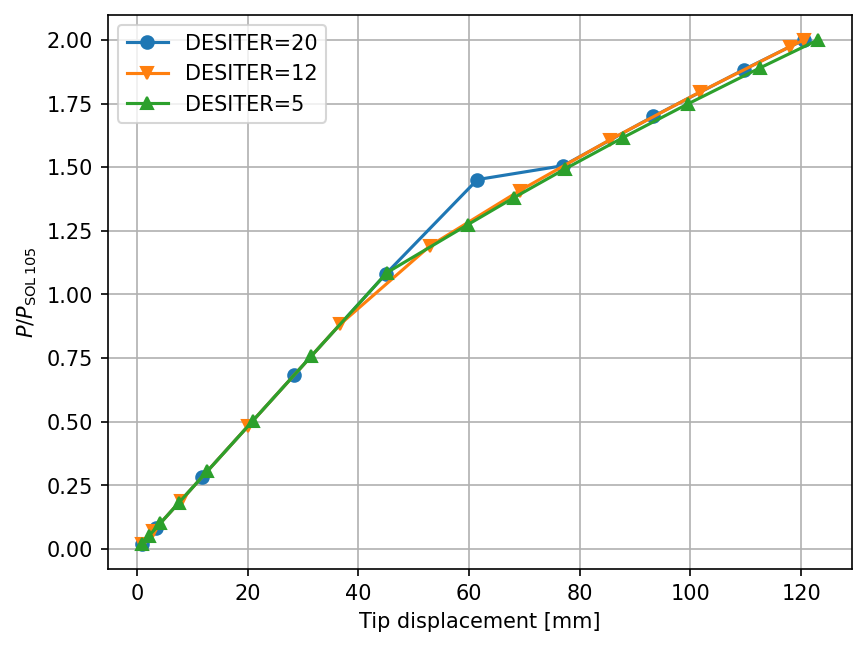

In [110]:
# Define desired numbers of iterations
no_iterations = [20, 12, 5]
# Create figure
_, ax = plt.subplots()
# Run analysis for each desired number of iterations and plot load-displacement diagram
for count, desiter in enumerate(no_iterations):
    box_beam_bdf_input.nlpcis[1].desiter = desiter
    input_filename = 'nonlinear_analysis_desiter_' + str(desiter)
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, debug=False)
    plot_load_displacement_path(op2_output, ax, markers[count], f'DESITER={desiter}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

Minimum allowable arc-length adjustment ratio.

Nastran job nonlinear_analysis_minalr_0_90.bdf completed
Wall time: 81.0 s


Nastran job nonlinear_analysis_minalr_0_25.bdf completed
Wall time: 83.0 s


Nastran job nonlinear_analysis_minalr_0_01.bdf completed
Wall time: 82.0 s


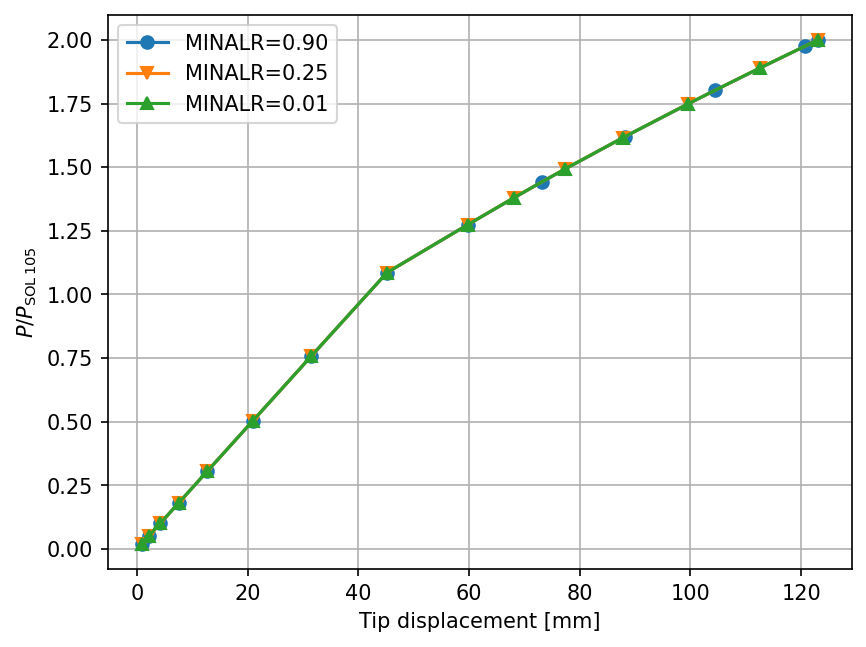

In [111]:
# Define minimum allowable arc-length adjustment ratios
min_arclength_adjustment_ratios = [.9, .25, .01]
# Create figure
_, ax = plt.subplots()
# Run analysis for each minimum allowable arc-length adjustment ratio and plot load-displacement diagram
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[1].minalr = minalr
    input_filename = f'nonlinear_analysis_minalr_{minalr:.2f}'.replace('.','_')
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, debug=False)
    plot_load_displacement_path(op2_output, ax, markers[count], f'MINALR={minalr:.2f}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

In [112]:
box_beam_bdf_input.nlpcis[1].minalr = .25

Maximum allowable arc-length adjusment ratio.

Nastran job nonlinear_analysis_maxalr_10_0.bdf completed
Wall time: 86.0 s


Nastran job nonlinear_analysis_maxalr_4_0.bdf completed
Wall time: 85.0 s


Nastran job nonlinear_analysis_maxalr_1_1.bdf completed
Wall time: 157.0 s


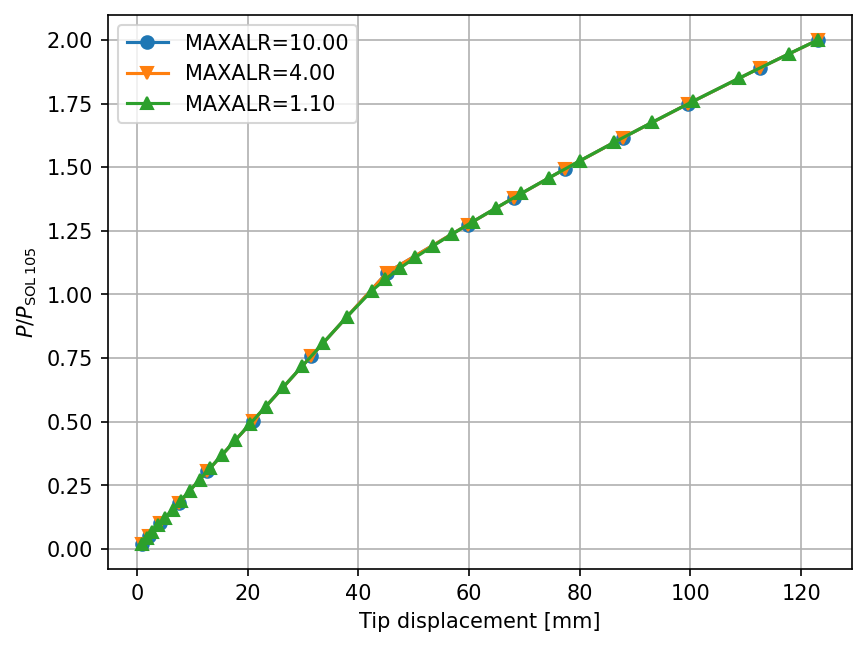

In [113]:
# Define maximum allowable arc-length adjustment ratios
max_arclength_adjustment_ratios = [10., 4., 1.1]
# Increase maximum number of controlled increments
box_beam_bdf_input.nlpcis[1].mxinc = 40
# Create figure
_, ax = plt.subplots()
# Run analysis for each maximum allowable arc-length adjustment ratio and plot load-displacement diagram
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[1].maxalr = maxalr
    input_filename = f'nonlinear_analysis_maxalr_{maxalr:.1f}'.replace('.','_')
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, debug=False)
    plot_load_displacement_path(op2_output, ax, markers[count], f'MAXALR={maxalr:.2f}')
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_\mathrm{SOL\/105}$')
plt.legend()
plt.grid()
plt.show()

## Nonlinear analysis: tangent stiffness matrix approach <a name="tangent-stiffness-matrix"></a>

In [114]:
# Restore default value for maximum allowable arc-lengtha adjustment ratio
box_beam_bdf_input.nlpcis[1].maxalr = 4.
# Define and print applied load magnitudes
applied_load_magnitudes = np.array([0.95, 2])*sol105_buckling_load
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')
# Modify first subcase
box_beam_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = applied_load_magnitudes[0]
# Create new subcase
load_set_id = load_set_id+1
box_beam_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[applied_load_magnitudes[1]], load_ids=[force_set_id])
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=2, load_set_id=load_set_id)

Applied loads [N]: [ 8003. 16848.]


In [115]:
# Add parameter for nonlinear buckling method
box_beam_bdf_input.add_param('BUCKLE', [2])
eigrl_set_id = load_set_id+1
box_beam_bdf_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)
box_beam_bdf_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)
# Include DMAP
box_beam_bdf_input.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigv_nobuckle.dmap') + '\'']  # include DMAP sequence

In [116]:
# Run analysis
input_filename = 'tangent_stiffness_matrix_approach'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)

Nastran job tangent_stiffness_matrix_approach.bdf completed
Wall time: 144.0 s


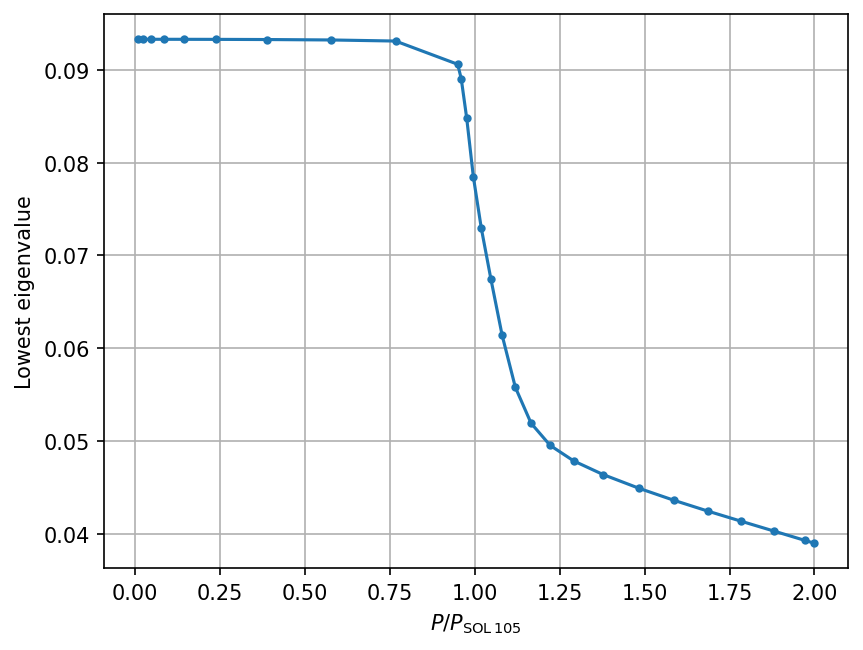

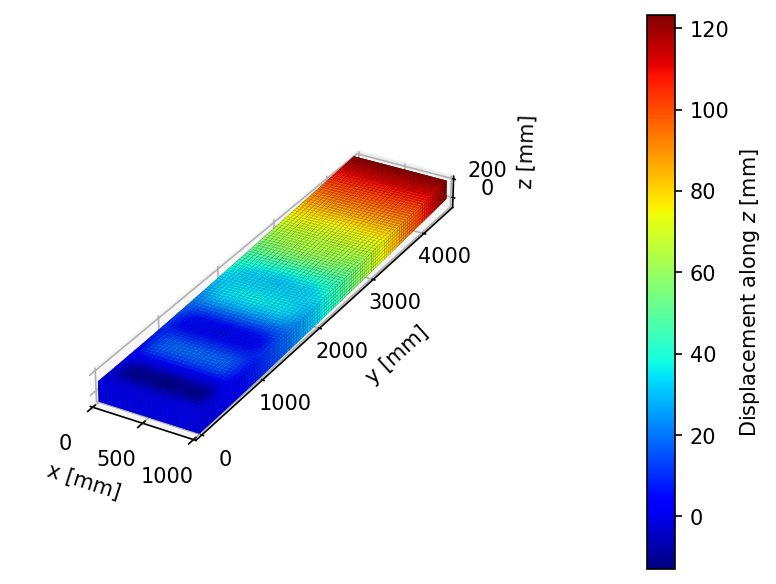

In [120]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False, load_geometry=True)
# Find load and displacement history
load_steps, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_master_node_id)
# Collect load and displacement history
load_history = np.concatenate([loads[subcase_id][:, load_component_index] for subcase_id in displacements])
displacement_history = np.concatenate([displacements[subcase_id][:,displacement_component_index] for subcase_id in displacements])
# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
# Create new figure and plot load history vs lowest eigenvalues
p_, ax = plt.subplots()
ax.plot(load_history/sol105_buckling_load, lowest_eigenvalues, '.-')
plt.xlabel('$P/P_\mathrm{SOL\/105}$')
plt.ylabel('Lowest eigenvalue')
plt.grid()
plt.show()
# Plot structural deformation
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=2, displacement_component='tz')
ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='z', nbins=2)
ax.tick_params(axis='y', which='major', pad=20)
ax.tick_params(axis='z', which='major', pad=6)
ax.yaxis.labelpad = 60
ax.zaxis.labelpad = 10
plt.show()

## Conclusions <a name="conclusions"></a>

***

In this notebook we have investigated the nonlinear behavior of a box beam reinforced with ribs and stiffeners. The results show a bifurcation break analogously to the previous cases of the unreinforced box beam and of the box beam reinforced with ribs only.

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [118]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()